参考
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [1]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.utils import download_url
import json

In [2]:
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
model.eval()
print("model")

model


In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

In [4]:
img = Image.open("cat.jpg")
print(type(img))
inputs = transform(img)
inputs = inputs.unsqueeze(0)
print(type(inputs))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'torch.Tensor'>


In [5]:
output = model(inputs)

In [6]:
batch_probs = F.softmax(output, dim = 1)
batch_probs, batch_indices = batch_probs.sort(dim = 1, descending=True)
print(batch_probs[0][0])
print(type(batch_probs), type(batch_indices))
print(batch_indices[0][0])
def get_classes():
    if not Path("data/imagenet_class_index.json").exists():
        # ファイルが存在しない場合はダウンロードする。
        download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

    # クラス一覧を読み込む。
    with open("data/imagenet_class_index.json") as f:
        data = json.load(f)
        class_names = [x["ja"] for x in data]

    return class_names


# クラス名一覧を取得する。
class_names = get_classes()

tensor(0.8991, grad_fn=<SelectBackward0>)
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor(285)


In [7]:
for probs, indices in zip(batch_probs, batch_indices):
    for k in range(3):
        print(f"Top-{k + 1} {class_names[indices[k]]} {probs[k]:.2%}")

Top-1 エジプトの猫 89.91%
Top-2 タビー 1.05%
Top-3 虎猫 0.57%


In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()


285

In [11]:
from lime import lime_image

In [13]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
from skimage.segmentation import mark_boundaries

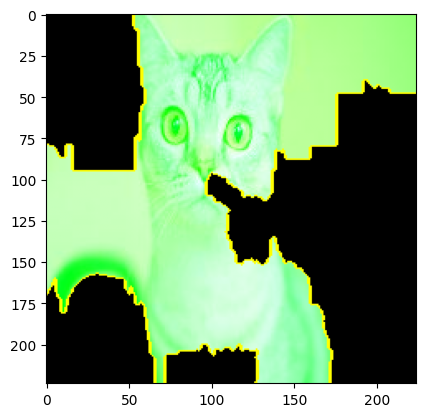

In [24]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

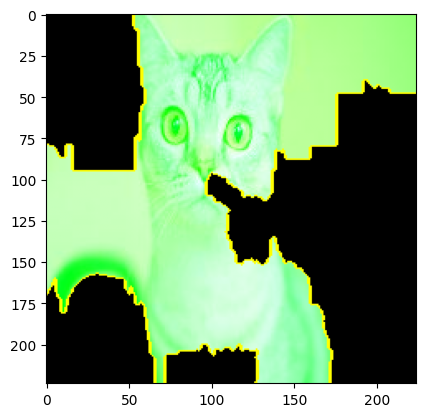

In [20]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)